In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import h5py
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d, interpn
import seaborn as sns
import sys
from tqdm import tqdm_notebook

d = 'vt'
try:
    sys.path.index(d)
except ValueError:
    sys.path.append(d)
    
import vt

sns.set_style('ticks')
sns.set_palette('colorblind')
sns.set_context('notebook')

In [3]:
MMin = 3
MMax = 50

def draw_m1m2(size=1):
    u1s = np.random.uniform(size=size)
    u2s = np.random.uniform(size=size)
    
    m1s = exp(log(MMin)*(1-u1s) + log(MMax)*u1s)
    m2s = m1s*u2s + MMin*(1-u2s)
    
    return (m1s, m2s)

In [4]:
R0 = 50.0 # Gpc^-3 yr^-1
T = 5 # yr
gamma = 2.7

zMax = 2.5

zs = expm1(linspace(log(1), log(1+zMax), 1024))
dNdz = T*R0*(1+zs)**(gamma-1)*4*pi*Planck15.differential_comoving_volume(zs).to(u.Gpc**3/u.sr).value
Nz = cumtrapz(dNdz, zs, initial=0)

icdf_z = interp1d(Nz/Nz[-1], zs)

def draw_z(factor=1):
    N = np.random.poisson(Nz[-1]*factor)
    
    return icdf_z(np.random.uniform(size=N))

In [5]:
def draw_ra_dec(size=1):
    ra = np.random.uniform(low=0, high=2*pi, size=size)
    sin_dec = np.random.uniform(low=-1, high=1, size=size)
    
    return ra, arcsin(sin_dec)

In [6]:
r_bao = 100/0.7/1000 # Gpc
w_bao = 15/0.7/1000 # Gpc
A_bao = 0.01

def xi_bao(r):
    return A_bao*exp(-0.5*square(r-r_bao)/(w_bao*w_bao))

cutoff_scale = 1/1000 # Gpc

def xi_pl(r):
    r = np.atleast_1d(r)
    a = 1.8
    
    return np.where(r < cutoff_scale, 1 - 0.1*(r/cutoff_scale), (r/cutoff_scale)**(-a)*0.9)

print('BAO correlation length is {:.3f} Gpc'.format(r_bao))
print('Width of BAO Gaussian is {:.3f} Gpc'.format(w_bao))

BAO correlation length is 0.143 Gpc
Width of BAO Gaussian is 0.021 Gpc


In [7]:
def bao_covariance(xs):
    rvec = xs[newaxis,:,:] - xs[:,newaxis,:]
    rs = np.sqrt(np.sum(rvec*rvec, axis=2))
    xi_rs = xi_bao(rs) + xi_pl(rs)
    
    return xi_rs

/Users/wfarr/anaconda3/envs/GWBAO/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in power
  


Text(0, 0.5, '$\\xi(r)$')

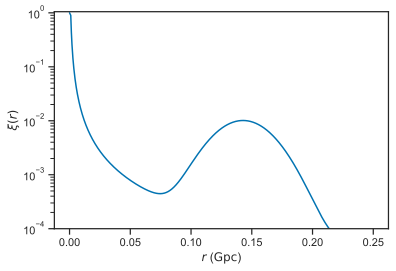

In [8]:
rs = linspace(0, 0.25, 1000)
xi_rs = xi_bao(rs) + xi_pl(rs)
plot(rs, xi_rs)
W_bao = trapz(4*pi*rs*rs*xi_rs, rs)

axis(ymin=1e-4)

yscale('log')

xlabel(r'$r$ ($\mathrm{Gpc}$)')
ylabel(r'$\xi(r)$')

In [9]:
rs = linspace(0, 1, 2048)
k8 = 1.0/(8/0.7/1000)/(2*pi) # 1/Gpc; note I am using inverse wavelength, not wavenumber (i.e. note the 2*pi)
P8 = trapz(2*rs*(xi_bao(rs) + xi_pl(rs))*sin(2*pi*k8*rs)/k8, rs)*1e9 # Mpc^3

/Users/wfarr/anaconda3/envs/GWBAO/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in power
  


In [10]:
print('Power on 8 Mpc scales is {:g} Mpc^3'.format(P8))
sigma_8 = 0.9 # Mpc^3
A2 = sigma_8/P8
print('So fractional amplitude variance parameter is {:g}'.format(A2))

Power on 8 Mpc scales is 695.182 Mpc^3
So fractional amplitude variance parameter is 0.00129463


In [15]:
fmin = 15.0
fref = 40.0
psdstart = 16.0

def next_pow_two(x):
    x2 = 1
    while x2 < x:
        x2 = x2 << 1
    
    return x2

def generate_waveform(m1, m2, z):
    dL = cosmo.Planck15.luminosity_distance(z).to(u.Gpc).value
    
    
    tmax = vt.ls.SimInspiralChirpTimeBound(fmin, m1*(1+z)*vt.lal.MSUN_SI, m2*(1+z)*vt.lal.MSUN_SI, 0.0, 0.0) + 2
    
    df = 1.0/next_pow_two(tmax)
    fmax = 2048.0 # Hz --- based on max freq of 5-5 inspiral
    
    cos_i = np.random.uniform(low=-1, high=1)
    phi_ref = np.random.uniform(low=0, high=2*pi)
    
    hp, hc = vt.ls.SimInspiralChooseFDWaveform((1+z)*m1*vt.lal.MSUN_SI, (1+z)*m2*vt.lal.MSUN_SI, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, dL*1e9*vt.lal.PC_SI, arccos(cos_i), phi_ref, 0.0, 0.0, 0.0, df, fmin, fmax, fref, None, vt.ls.IMRPhenomPv2)
    
    return hp, hc

def compute_detector_snrs(hp, hc, ra, dec):
    psi = np.random.uniform(low=0, high=2*pi)
    gmst = np.random.uniform(low=0, high=2*pi)
    
    snrs = []
    for det in ['H1', 'L1', 'V1']:
        Fp, Fc = vt.lal.ComputeDetAMResponse(vt.lal.cached_detector_by_prefix[det].response, ra, dec, psi, gmst)
        
        h = vt.lal.CreateCOMPLEX16FrequencySeries("h", vt.lal.LIGOTimeGPS(0), 0.0, hp.deltaF, hp.sampleUnits, hp.data.length)
        h.data.data = Fp*hp.data.data + Fc*hc.data.data
        
        fmax = hp.deltaF*(hp.data.length - 1)
        df = hp.deltaF
        Nf = hp.data.length

        fs = linspace(0, fmax, Nf)
        sel = fs > psdstart

        sffs = vt.lal.CreateREAL8FrequencySeries("psds", 0, 0.0, df, vt.lal.DimensionlessUnit, fs.shape[0])
        if det == 'H1' or det == 'L1':
            vt.ls.SimNoisePSDaLIGOaLIGODesignSensitivityT1800044(sffs, psdstart)
        elif det == 'V1':
            vt.ls.SimNoisePSDAdVDesignSensitivityP1200087(sffs, psdstart)
        else:
            raise ValueError('detector must be one of H1, L1, V1')
        
        rho = vt.ls.MeasureSNRFD(h, sffs, 20.0, -1.0)
        n = randn()
        
        snrs.append(sqrt((rho+n)*(rho+n)))
        
    return array(snrs)

def approx_mdet_threshold(z):
    z0 = 0.5
    m1 = 30
    z1 = 2.5
    return m1*(z-z0)/(z1-z0)

def downselect(m1s, m2s, zs, ras, decs):
    m1s_sel = []
    m2s_sel = []
    zs_sel = []
    ras_sel = []
    decs_sel = []
    snrs_sel = []
    
    s = m1s > approx_mdet_threshold(zs)
    
    for m1, m2, z, ra, dec in zip(tqdm_notebook(m1s[s]), m2s[s], zs[s], ras[s], decs[s]):
        # By observation, this curve bounds the hopeless detections
        if m1 < approx_mdet_threshold(z):
            continue
        
        hp, hc = generate_waveform(m1, m2, z)
        snrs = compute_detector_snrs(hp, hc, ra, dec)
        snr = np.sqrt(np.sum(snrs*snrs))
        
        if snr > 8:
            m1s_sel.append(m1)
            m2s_sel.append(m2)
            zs_sel.append(z)
            ras_sel.append(ra)
            decs_sel.append(dec)
            snrs_sel.append(snr)
            
    return array(m1s_sel), array(m2s_sel), array(zs_sel), array(ras_sel), array(decs_sel), array(snrs_sel)

In [16]:
f = 1 + 5*sqrt(A2)
print('Factor = {:.2f}'.format(f))

zs = draw_z(factor=f)
N = len(zs)
m1s, m2s = draw_m1m2(size=N)
ras, decs = draw_ra_dec(size=N)

m1s_sel, m2s_sel, zs_sel, ras_sel, decs_sel, snrs_sel = downselect(m1s, m2s, zs, ras, decs)

Factor = 1.18


KeyboardInterrupt: 

/Users/wfarr/anaconda3/envs/GWBAO/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/wfarr/anaconda3/envs/GWBAO/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


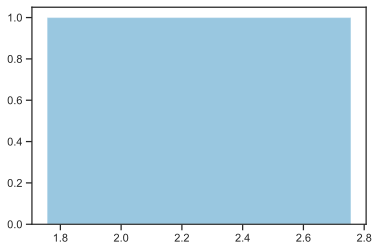

In [86]:
sns.distplot(zs_sel)

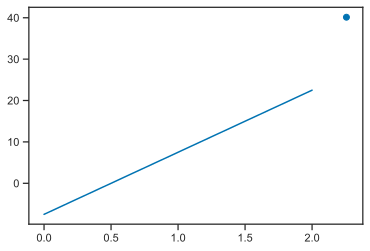

In [87]:
scatter(zs_sel, m1s_sel)
z = linspace(0, zMax ,100)
plot(z, approx_mdet_threshold(z))